<a href="https://colab.research.google.com/github/BiakkoNoMiko/homework_projects/blob/main/IMDB_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U git+https://github.com/huggingface/transformers@de9255de27abfcae4a1f816b904915f0b1e23cd9
!pip install torch --upgrade
!pip install datasets==2.10.1 evaluate
!pip install -q git+https://github.com/huggingface/accelerate.git
!pip install transformers[torch]
!pip install evaluate
!pip install Xformers

  Cloning https://github.com/huggingface/transformers (to revision de9255de27abfcae4a1f816b904915f0b1e23cd9) to /tmp/pip-req-build-1o5uso9v
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-1o5uso9v
  Running command git rev-parse -q --verify 'sha^de9255de27abfcae4a1f816b904915f0b1e23cd9'
  Running command git fetch -q https://github.com/huggingface/transformers de9255de27abfcae4a1f816b904915f0b1e23cd9
  Running command git checkout -q de9255de27abfcae4a1f816b904915f0b1e23cd9
  Resolved https://github.com/huggingface/transformers to commit de9255de27abfcae4a1f816b904915f0b1e23cd9
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/

In [2]:
#Visualization
import seaborn as sns
import matplotlib.pyplot as plt

#System and standart
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
tqdm.pandas(desc="my bar!")
import time

#HF models
import torch
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline
from evaluate import evaluator
import evaluate

## huggingface login and GPU info

In [ ]:
!nvidia-smi

Sun Jul 16 13:27:50 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

#Loading Data

In [3]:
# get IMDB Dataset: http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

--2023-07-18 14:23:56--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  24.2MB/s    in 3.3s    

2023-07-18 14:24:00 (24.2 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [4]:
# extract downloaded files
!tar xvzf aclImdb_v1.tar.gz

Выходные данные были обрезаны до нескольких последних строк (5000).
aclImdb/train/unsup/44983_0.txt
aclImdb/train/unsup/44982_0.txt
aclImdb/train/unsup/44981_0.txt
aclImdb/train/unsup/44980_0.txt
aclImdb/train/unsup/44979_0.txt
aclImdb/train/unsup/44978_0.txt
aclImdb/train/unsup/44977_0.txt
aclImdb/train/unsup/44976_0.txt
aclImdb/train/unsup/44975_0.txt
aclImdb/train/unsup/44974_0.txt
aclImdb/train/unsup/44973_0.txt
aclImdb/train/unsup/44972_0.txt
aclImdb/train/unsup/44971_0.txt
aclImdb/train/unsup/44970_0.txt
aclImdb/train/unsup/44969_0.txt
aclImdb/train/unsup/44968_0.txt
aclImdb/train/unsup/44967_0.txt
aclImdb/train/unsup/44966_0.txt
aclImdb/train/unsup/44965_0.txt
aclImdb/train/unsup/44964_0.txt
aclImdb/train/unsup/44963_0.txt
aclImdb/train/unsup/44962_0.txt
aclImdb/train/unsup/44961_0.txt
aclImdb/train/unsup/44960_0.txt
aclImdb/train/unsup/44959_0.txt
aclImdb/train/unsup/44958_0.txt
aclImdb/train/unsup/44957_0.txt
aclImdb/train/unsup/44956_0.txt
aclImdb/train/unsup/44955_0.txt
aclI

In [5]:
def fetch_reviews(path):
  data = []
  #path = 'aclImdb/train/pos/'
  files = [f for f in os.listdir(path)]
  for file in files:
    with open(path+file, "r", encoding='utf8') as f:
      data.append(f.read())

  return data

In [6]:
df_train_pos = pd.DataFrame({'review': fetch_reviews('aclImdb/train/pos/'), 'label': 1})
df_train_neg = pd.DataFrame({'review': fetch_reviews('aclImdb/train/neg/'), 'label': 0})

df_test_pos = pd.DataFrame({'review': fetch_reviews('aclImdb/test/pos/'), 'label': 1})
df_test_neg = pd.DataFrame({'review': fetch_reviews('aclImdb/test/neg/'), 'label': 0})

# Merging all df's
df = pd.concat([df_train_pos, df_train_neg, df_test_pos, df_test_neg], ignore_index=True)
df.head()

,review,label
0,I love this film and it is such a wonderful ex...,1
1,"""Markham,"" says urbane gentleman crime-solver ...",1
2,"First off, consider that this film is nearly f...",1
3,fascinating look at fascist italy and the peop...,1
4,With part reconstruction and part direct shoot...,1


In [ ]:
df.shape

(50000, 2)

## EDA

In [ ]:
# look at percentage of Nans
null_values=pd.DataFrame(df.isna().sum(), columns=['NaN'])
null_values['percent'] = null_values/len(df) * 100
null_values.sort_values('percent', ascending=False).round(2)

,NaN,percent
review,0,0.0
label,0,0.0


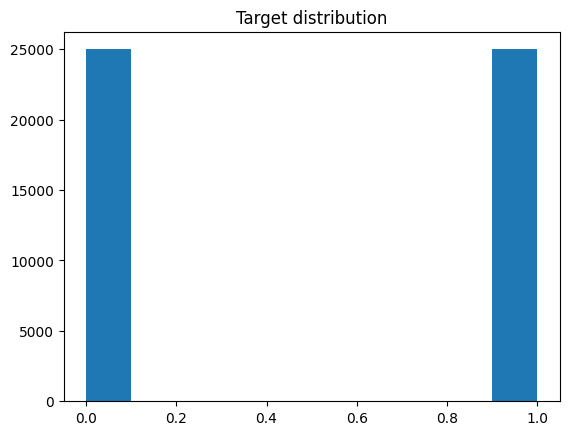

In [ ]:
plt.hist(df['label'])
plt.title('Target distribution');

Dataset contains equal amount of positive and negative reviews.

In [ ]:
print(f'sample of a positive review: {df[df["label"] == 1].sample(n = 1)["review"].iloc[0]}')
print(f'sample of a negative review: {df[df["label"] == 0].sample(n = 1)["review"].iloc[0]}')

sample of a positive review: This movie is incredible.With great characters,specially the old swordsman that can fly in the shape of fireball and jump across the trees,this film tells a classic story of battle between good and forces of evil.The final showdown is specially breathtaking and the music score is kinda cool.<br /><br />Very,very recommendable.Not for the smallest children though.This one deserves a 10.
sample of a negative review: With no fault to the actors (they all put on great performances), the overall story was not very well executed. The movie opens with a great zinger: a crazy old guy forces a young Aborigine girl's car off the road. But then, we're forced to endure 40 minutes of character development with an entirely new group of characters ... and we don't know why until the 40 minutes are up. It turns out that they are the ones who eventually discover the girl's body ... and the story progresses from there.<br /><br />While the story does pick up at that point, i

In [7]:
word_counter = df['review'].apply(lambda x: len(x.split()))

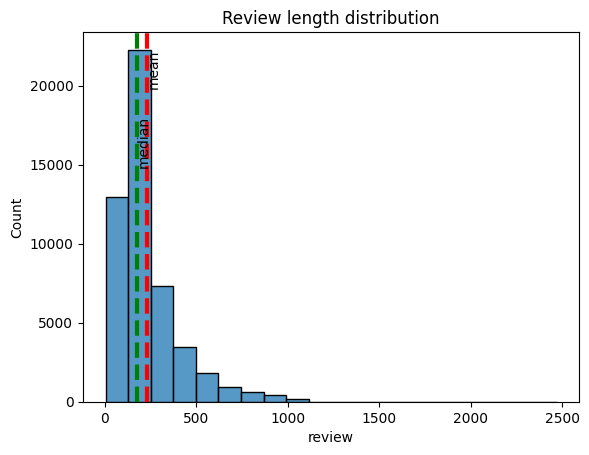

In [24]:
sns.histplot(data=word_counter, bins=20, kde=False, log_scale=False)
plt.axvline(word_counter.median(), color='Green', linestyle='dashed', linewidth=3, label = f'Median: {word_counter.median()}')
plt.text(word_counter.median(), 15000, 'median', rotation = 90)
plt.axvline(word_counter.mean(), color='red', linestyle='dashed', linewidth=3, label = f'Mean: {word_counter.median()}')
plt.text(word_counter.mean(), 20000, 'mean', rotation = 90)
plt.title('Review length distribution');

In [25]:
word_counter.mean()

231.15694

In [26]:
word_counter.median()

173.0

#Baseline (classic LM)

In [27]:
#NLP
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download("stopwords")
nltk.download('punkt')
import re
from sklearn.feature_extraction.text import TfidfVectorizer

# Classic ML
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [28]:
# Vectorize texts
vec = TfidfVectorizer(stop_words=stopwords.words('english'),
                        max_features=1000,
                        ngram_range=(2,4))
bow = vec.fit_transform(df['review'])

In [29]:
X_train, X_test, y_train, y_test = train_test_split(bow, df.label, test_size=0.2, random_state=42)

In [32]:
models = [LogisticRegression(random_state=42, max_iter = 3000),
          SVC(gamma='auto'),
          RandomForestClassifier(min_samples_leaf=2, criterion='gini'),
          KNeighborsClassifier(),
          XGBClassifier()
          ]

In [31]:
# DF to compare models
compare_models = []

#Loop on every model in list
for model in models:
    classification_model = make_pipeline(StandardScaler(with_mean=False), model)
    classification_model.fit(X_train, y_train)
    y_pred = classification_model.predict(X_test)

    #Print scores for each model
    print(f'metrics for {model}')
    print('_'*100)
    print(classification_report(y_test, y_pred))
    print()


    compare_models.append({'Name': re.findall(r'^\w+', str(model))[0], #
                       'Test_score': classification_model.score(X_test, y_test),
                       'Train_score': classification_model.score(X_train, y_train)})

#Print comparison df
compare_models = pd.DataFrame(compare_models)
compare_models
compare_models.sort_values(['Test_score'], ascending = False)

metrics for LogisticRegression(max_iter=3000, random_state=42)
____________________________________________________________________________________________________
              precision    recall  f1-score   support

           0       0.75      0.72      0.74      4945
           1       0.74      0.76      0.75      5055

    accuracy                           0.74     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.74      0.74      0.74     10000


metrics for SVC(gamma='auto')
____________________________________________________________________________________________________
              precision    recall  f1-score   support

           0       0.74      0.71      0.73      4945
           1       0.73      0.76      0.74      5055

    accuracy                           0.74     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.74      0.74      0.74     10000


metrics for RandomForestClassifier(min_samples_le

,Name,Test_score,Train_score
0,LogisticRegression,0.7427,0.765025
1,SVC,0.7367,0.888775
2,RandomForestClassifier,0.7289,0.877125
4,XGBClassifier,0.7227,0.782675
3,KNeighborsClassifier,0.5870,0.757075


# Bert-like models

For text classification tasks one of the best choises is bert-like model. We can fine-tune basic model on our dataset using torch / keras, but i found an already fine-tuned model (3 epochs), so to save resources i'll use this fine-tuned model and huggingface's pipelines

## Preproc

In [9]:
tokenizer = AutoTokenizer.from_pretrained("lvwerra/bert-imdb")
model = AutoModelForSequenceClassification.from_pretrained("lvwerra/bert-imdb")

pipe = pipeline("sentiment-analysis", model="lvwerra/bert-imdb")

In [10]:
#Create dataset from pandas df
dataset = Dataset.from_pandas(df)

In [11]:
dataset

Dataset({
    features: ['review', 'label'],
    num_rows: 50000
})

In [ ]:
#i think there is no need in this for now. Because we will not train the model
#dataset.train_test_split(test_size=0.3)

## Evaluation of the model

In [18]:
clf_metrics = evaluate.combine(["accuracy", "f1", "precision", "recall"])

task_evaluator = evaluator("text-classification")

In [ ]:
# Take samples from ds
data=dataset.shuffle().select(range(1000))

In [ ]:
data

Dataset({
    features: ['review', 'label'],
    num_rows: 1000
})

In [ ]:
results = task_evaluator.compute(
    model_or_pipeline=pipe,
    data=data,
    input_column="review",
    label_column="label",
    metric=clf_metrics,
    label_mapping={"LABEL_0": 0, "LABEL_1": 1},
    random_state=42
)

In [ ]:
results

{'accuracy': 0.96,
 'f1': 0.9598393574297188,
 'precision': 0.9617706237424547,
 'recall': 0.9579158316633266,
 'total_time_in_seconds': 3411.2249065359997,
 'samples_per_second': 0.2931498295770451,
 'latency_in_seconds': 3.411224906536}

Not bad

## Inference

In [12]:
import joblib

filename= 'saved_IMDB_model.sav'
saved_model=joblib.dump(model,filename)
saved_pipe=joblib.dump(pipe,'saved_IMDB_pipe.sav')

In [ ]:
from google.colab import files
files.download('/content/saved_IMDB_pipe.sav')

In [ ]:
files.download('/content/saved_IMDB_model.sav')

In [128]:
text = "sometimes boring"

pred = pipe(text)
pred

[{'label': 'LABEL_1', 'score': 0.774403989315033}]

In [ ]:
pred[0]['label']

## Ratings

We have sentiment scores from 0 to 1, which shows how strong the sentiment is. Let's convert it to the ratings from 1 to 10. So, to get 1-10 rating we'll need to multiply the score by 10 and add 1 (to avoid zero) for positive reviews. For negative reviews, let's subtract the same amount from 10

In [129]:
def result(text):
  pred = pipe(text)

  if pred[0]['label'] == 'LABEL_1':
    rating = int(pred[0]['score'] * 10) + 1
    return 'POSITIVE', rating
  else:
    rating = int(11 - (pred[0]['score'] * 10))
    return 'NEGATIVE', rating

In [140]:
text = "not so good"
result(text)

('NEGATIVE', 1)